In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.special as special
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
#from lmfit import Model
from scipy.integrate import odeint
from numpy import array, dot, pi
from scipy.integrate import complex_ode
from scipy import integrate
from tqdm import tqdm
from scipy.sparse.linalg import eigsh 

In [2]:
def X(i,L):
    op=np.array([[0,1],[1,0]])
    if 1 < i  and i<L:
        Op_i=np.kron(np.kron(np.eye(2**(i-1)),op),np.eye(2**(L-i)))
    if i==1:
        Op_i=np.kron(op,np.eye(2**(L-1)))
    if i==L:
        Op_i=np.kron(np.eye(2**(L-1)),op)
        
    return Op_i

def Z(i,L):
    op=np.array([[1,0],[0,-1]])
    if 1 < i  and i<L:
        Zi=np.kron(np.kron(np.eye(2**(i-1)),op),np.eye(2**(L-i)))
    if i==1:
        Zi=np.kron(op,np.eye(2**(L-1)))
    if i==L:
        Zi=np.kron(np.eye(2**(L-1)),op)
    return Zi

def Y(i,L):
    op=np.array([[0,-1j],[1j,0]])
    if 1 < i  and i<L:
        Yi=np.kron(np.kron(np.eye(2**(i-1)),op),np.eye(2**(L-i)))
    if i==1:
        Yi=np.kron(op,np.eye(2**(L-1)))
    if i==L:
        Yi=np.kron(np.eye(2**(L-1)),op)
    return Yi

Link opertor

In [3]:
def V(Lam):
    U1=np.zeros([2*Lam,2*Lam])
    U1[0,2*Lam-1]=1
    
    for i in range(2*Lam-1):
        U1[i+1,i]=1
        
    return U1


def V_dag(Lam):
    U1=np.zeros([2*Lam,2*Lam])
    U1[2*Lam-1,0]=1
    
    for i in range(2*Lam-1):
        U1[i,i+1]=1
    
    return U1

In [4]:
def U(i,Lam,L):
    op=V(Lam)
    if 1 < i  and i<L:
        op_i=np.kron(np.kron(np.eye((2*Lam)**(i-1)),op),np.eye((2*Lam)**(L-i)))
    if i==1:
        op_i=np.kron(op,np.eye((2*Lam)**(L-1)))
    if i==L:
        op_i=np.kron(np.eye((2*Lam)**(L-1)),op)
        
    return op_i

def U_dag(i,Lam,L):
    op=V_dag(Lam)
    if 1 < i  and i<L:
        op_i=np.kron(np.kron(np.eye((2*Lam)**(i-1)),op),np.eye((2*Lam)**(L-i)))
    if i==1:
        op_i=np.kron(op,np.eye((2*Lam)**(L-1)))
    if i==L:
        op_i=np.kron(np.eye((2*Lam)**(L-1)),op)
        
    return op_i

In [5]:
def E(Lam):
    U1=np.zeros([2*Lam,2*Lam])
    for i in range(2*Lam):
        U1[i,i]=-Lam+i
        
    return U1

In [6]:
E(4).dot(V_dag(4))-V_dag(4).dot(E(4))+V_dag(4)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [8., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
def E2(i,Lam,L):
    X=E(Lam).dot(E(Lam))
    if 1 < i  and i<L:
        Xi=np.kron(np.kron(np.eye((2*Lam)**(i-1)),X),np.eye((2*Lam)**(L-i)))
    if i==1:
        Xi=np.kron(X,np.eye((2*Lam)**(L-1)))
    if i==L:
        Xi=np.kron(np.eye((2*Lam)**(L-1)),X)
        
    return Xi

In [8]:
def Ham_XX(Lam,L):
    H=np.kron((U(L,Lam,L)+U_dag(L,Lam,L)), X(L,L).dot(X(1,L)))
    for i in range(1,L):
        H+=np.kron((U(i,Lam,L)+U_dag(i,Lam,L)), X(i,L).dot(X(i+1,L)))
        
    return 0.25*H

In [9]:
def Ham_YY(Lam,L):
    H=np.kron((U(L,Lam,L)+U_dag(L,Lam,L)), Y(L,L).dot(Y(1,L)))
    for i in range(1,L):
        H+=np.kron((U(i,Lam,L)+U_dag(i,Lam,L)), Y(i,L).dot(Y(i+1,L)))
        
    return 0.25*H

In [10]:
def Ham_XY(Lam,L):
    H=np.kron((U(L,Lam,L)-U_dag(L,Lam,L)), X(L,L).dot(Y(1,L)))
    for i in range(1,L):
        H+=np.kron((U(i,Lam,L)-U_dag(i,Lam,L)), X(i,L).dot(Y(i+1,L)))
        
    return 0.25j*H

In [11]:
def Ham_YX(Lam,L):
    H=np.kron((U(L,Lam,L)-U_dag(L,Lam,L)), Y(L,L).dot(X(1,L)))
    for i in range(1,L):
        H+=np.kron((U(i,Lam,L)-U_dag(i,Lam,L)), Y(i,L).dot(X(i+1,L)))
        
    return -0.25j*H

In [12]:
def Ham_Z(m, Lam,L):
    H=np.kron(np.eye((2*Lam)**L) , Z(L,L))
    for i in range(1,L):
        H+=np.kron(np.eye((2*Lam)**L) , Z(i,L))
        
    return 0.5*m*H

In [13]:
def Ham_E(g, Lam,L):
    H=np.kron( E2(L,Lam,L) , np.eye(2**L))
    for i in range(1,L):
        H+=np.kron( E2(i,Lam,L) , np.eye(2**L))
        
    return (0.5*g**2)*H

In [14]:
Ham_XX(2,3)+Ham_XY(2,3)+Ham_YX(2,3)+Ham_XX(2,3)+Ham_Z(1,2,3)+Ham_E(1,2,3)

array([[7.5+0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 6.5+0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 6.5+0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       ...,
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 1. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 1. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j]])

In [15]:
def Ham_0(m,g, Lam,L):
    return Ham_XX(Lam,L)+Ham_XY(Lam,L)+Ham_YX(Lam,L)+Ham_XX(Lam,L)+Ham_Z(m,Lam,L)+Ham_E(g,Lam,L)
    

In [43]:
from scipy import sparse
from scipy.sparse import csr_matrix
def ext(t,Lam,L,k):
    OP=np.eye((2*Lam)**L)
    #OP=sparse.csr_matrix(np.eye((2*Lam)**L))
    
    if t> 1:
        OP=OP.dot(dot(U(1,Lam,L), U(L,Lam,L) ))
        
    if t>2:
        OP=OP.dot(dot(np.linalg.matrix_power(U(2,Lam,L), 2), np.linalg.matrix_power(U(L-1,Lam,L), 2)))
        
    if t>3:
        OP=OP.dot(dot(np.linalg.matrix_power(U(3,Lam,L), 3), np.linalg.matrix_power(U(L-2,Lam,L), 3)))
        
    if t>4:
        OP=OP.dot(dot(np.linalg.matrix_power(U(4,Lam,L), 4), np.linalg.matrix_power(U(L-3,Lam,L), 4)))

    if t>5:
        OP=OP.dot(dot(np.linalg.matrix_power(U(5,Lam,L), 5), np.linalg.matrix_power(U(L-4,Lam,L), 5)))
        
    if t>6:
        OP=OP.dot(dot(np.linalg.matrix_power(U(6,Lam,L), 6), np.linalg.matrix_power(U(L-5,Lam,L), 6)))
            
    OP=np.kron(OP,np.eye(2**L))
    
    for i in range(k):
        OP=scipy.linalg.sqrtm(OP)
    
    return OP

In [17]:
sparse.csr_matrix(np.eye(2))

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [19]:
ext(1,2,4,2)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [44]:
def evolv_XX(t,Lam,L,k):
    return expm(-1j*(t/k)*Ham_XX(Lam,L))

def evolv_XY(t,Lam,L,k):
    return expm(-1j*(t/k)*Ham_XY(Lam,L))

def evolv_YX(t,Lam,L,k):
    return expm(-1j*(t/k)*Ham_YX(Lam,L))

def evolv_YY(t,Lam,L,k):
    return expm(-1j*(t/k)*Ham_YY(Lam,L))

def evolv_Z(t,m, Lam,L,k):
    return expm(-1j*(t/k)*Ham_Z(m,Lam,L))

def evolv_E(t,g, Lam,L,k):
    return expm(-1j*(t/k)*Ham_E(g, Lam,L))

In [45]:
def evolv(t,m,g,Lam,L,k):
    M=evolv_XX(t,Lam,L,k).dot(evolv_XY(t,Lam,L,k))
    M=M.dot(evolv_YX(t,Lam,L,k))
    M=M.dot(evolv_YY(t,Lam,L,k))
    M=M.dot(evolv_Z(t,m,Lam,L,k))
    M=M.dot(evolv_E(t,g,Lam,L,k))
    M=M.dot(ext(t,Lam,L,k))
    
    return np.linalg.matrix_power(M, k)
    

In [22]:
evolv(4.3,1,1,2,4,3)

array([[ 1.29239189e-01-2.13928246e-01j,  1.76118964e-16-4.84892172e-16j,
         3.80654678e-17-3.64272629e-16j, ...,
        -1.83794919e-16-3.77117200e-16j, -4.31987753e-16-1.82071029e-16j,
         1.53144593e-16+2.13057284e-16j],
       [-3.13576841e-17-5.12198010e-16j,  1.05070203e-01-5.15413552e-02j,
         1.94561140e-16-1.83751263e-16j, ...,
        -3.93697201e-16+6.07229104e-16j,  1.55698180e-17+5.17595803e-16j,
        -3.70945881e-16+2.06050769e-16j],
       [-2.17996182e-16+3.86696206e-16j,  3.98229579e-16-4.67000850e-16j,
         1.05070203e-01-5.15413552e-02j, ...,
        -1.70993237e-16-1.60946387e-16j, -2.68139524e-16+1.55605649e-16j,
        -1.72721769e-16+7.34376211e-17j],
       ...,
       [ 3.68801741e-16-5.40461124e-16j,  1.27024285e-16-4.12264212e-17j,
        -6.75282658e-16-4.47666560e-16j, ...,
         1.10549402e-01+1.93040792e-01j,  1.52125418e-16-3.70378180e-16j,
        -2.69540555e-16+9.08014787e-18j],
       [-7.47552952e-17-3.55798979e-16j, -2.

In [46]:
def Ene(t,m,g,Lam,L,k):
    eig_val, eig_vec=eigsh(Ham_0(m,g, Lam,L), k=1, which="SA")
    idx = eig_val.argsort()[::1]
    eig_val_sorted = eig_val[idx]
    eig_vec_sorted =np.transpose(eig_vec[:,idx])
    
    u=eig_vec_sorted[0]#/float(np.sqrt(np.dot(np.conjugate(eig_vec_sorted[0]),eig_vec_sorted[0])))
    
    #return np.dot(np.conjugate(eig_vec_sorted[0]),np.dot(commn, eig_vec_sorted[0]))
    
    
    return np.dot(np.conjugate(u),np.dot(evolv(t,m,g,Lam,L,k), u))
    

In [21]:
x=[0.2*s for s in range(24)]
y=[Ene(0.2*s,1,1,2,4,3) for s in tqdm(range(24))]

100%|██████████| 24/24 [1:37:31<00:00, 243.82s/it]


In [49]:
x2=[0.05*s for s in range(96)]
y2=[Ene(0.05*s,1,1,1,6,3) for s in tqdm(range(96))]


100%|██████████| 96/96 [5:42:31<00:00, 214.08s/it]


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


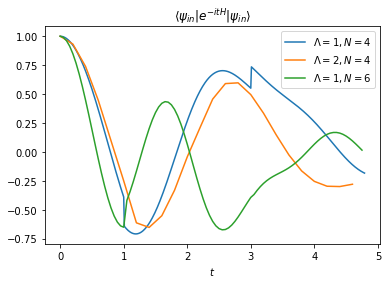

In [50]:
plt.plot(x1,y1,label="$\Lambda=1,N=4$")
plt.plot(x,y, label="$\Lambda=2, N=4$")
plt.plot(x2,y2,label="$\Lambda=1,N=6$")
plt.xlabel("$t$")
plt.title(r'$\langle\psi_{in}|e^{-itH}|\psi_{in}\rangle$')
plt.legend()
plt.savefig("Amplitude.pdf")

In [52]:
def j0(t,n):
    j=0
    if t==n:
        j=1
        
    return j

In [84]:
def Q(n,t,g,Lam,L):
    IZZ=np.kron(np.eye((2*Lam)**L), Z(n,L)) 
    II=np.kron(np.eye((2*Lam)**L), np.eye(2**L)) 
    
    return 0.5*IZZ+(0.5*(-1)**n)*II-(j0(t,n)/g)*II

In [87]:
Q(4,0,1,1,4)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [88]:
def Electric(t,n,m,g,Lam,L,k):
    eig_val, eig_vec=eigsh(Ham_0(m,g, Lam,L), k=1, which="SA")
    idx = eig_val.argsort()[::1]
    eig_val_sorted = eig_val[idx]
    eig_vec_sorted =np.transpose(eig_vec[:,idx])
    
    u=eig_vec_sorted[0]#/float(np.sqrt(np.dot(np.conjugate(eig_vec_sorted[0]),eig_vec_sorted[0])))
    
    #return np.dot(np.conjugate(eig_vec_sorted[0]),np.dot(commn, eig_vec_sorted[0]))
    
    psi=np.dot(evolv(t,m,g,Lam,L,k), u)
    
    return ((-1)**n)*np.dot(np.conjugate(psi),dot(Q(n,t,g,Lam,L),psi))

In [89]:
def Electric_tot(t,m,g,Lam,L,k):
    EE=Electric(t,L,m,g,Lam,L,k)
    for n in range(1,L):
        EE+=Electric(t,n,m,g,Lam,L,k)
    
    return EE

In [90]:
x_E=[0.2*s for s in range(24)]
y_E=[Electric_tot(0.2*s,1,1,1,4,3) for s in tqdm(range(24))]



  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:15,  1.51it/s]

  8%|▊         | 2/24 [00:01<00:14,  1.47it/s]

 12%|█▎        | 3/24 [00:02<00:14,  1.45it/s]

 17%|█▋        | 4/24 [00:02<00:13,  1.45it/s]

 21%|██        | 5/24 [00:03<00:13,  1.46it/s]

 25%|██▌       | 6/24 [00:04<00:12,  1.40it/s]

 29%|██▉       | 7/24 [00:05<00:14,  1.20it/s]

 33%|███▎      | 8/24 [00:06<00:14,  1.13it/s]

 38%|███▊      | 9/24 [00:07<00:13,  1.08it/s]

 42%|████▏     | 10/24 [00:08<00:13,  1.04it/s]

 46%|████▌     | 11/24 [00:09<00:13,  1.00s/it]

 50%|█████     | 12/24 [00:10<00:12,  1.07s/it]

 54%|█████▍    | 13/24 [00:11<00:11,  1.07s/it]

 58%|█████▊    | 14/24 [00:12<00:10,  1.08s/it]

 62%|██████▎   | 15/24 [00:13<00:09,  1.08s/it]

 67%|██████▋   | 16/24 [00:15<00:08,  1.09s/it]

 71%|███████   | 17/24 [00:16<00:07,  1.11s/it]

 75%|███████▌  | 18/24 [00:17<00:06,  1.11s/it]

 79%|███████▉  | 19/24 [00:18<00:05,  1.12s/it]

 83%|████████▎ | 20/24 [00:19<00:04,

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


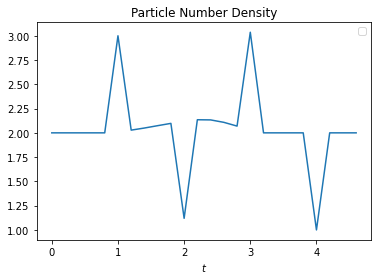

In [99]:
plt.plot(x_E,y_E)
plt.xlabel("$t$")

plt.title(r'Particle Number Density')
plt.legend()
plt.savefig("ParticleNumberDensity.pdf")